# Notes

Important to note is that the time in the datetime, denoted as "15:00:00" for instance, refers to the start of the product. So "15:00:00" refers to delivery hour 15:00–16:00. The Excel sheets often denote products by the numbered hour of the day, 1H-16 for instance. Thus, "15:00:00" corresponds with product code: 1H-16.

# Preamble

In [1]:
import os
os.system('clear')

import numpy as np
import pandas as pd
from datetime import datetime

from termcolor import colored
from SecretColors.palette import Palette
material = Palette("material", color_mode = 'hexa')

hex_salmon = '#F68F83'
hex_gold = '#BC9661'
hex_indigo = '#2D2E5F'
hex_maroon = '#8C4750'
hex_white = '#FAFAFA'
hex_blue = '#7EB5D2'

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates
mpl.rcParams['font.family'] = 'SF Compact Text'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.titleweight'] = 'semibold'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[hex_indigo, hex_salmon, hex_maroon])
mpl.rcParams["figure.titlesize"] = 'large'
mpl.rcParams["figure.titleweight"] = 'semibold'

print('')
print(colored('...','white'))
print('')
print(colored(f'Finished successfully', 'green'))
print('')
print(colored('...','white'))
print('')


...

Finished successfully

...



# Specify period

In [2]:
# years = ['2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
years = ['2015','2016','2017','2018','2019','2020']
years = ['2010', '2011', '2012', '2013', '2014','2015','2016','2017','2018','2019']
country = 'NL'

# Converting intraday (raw) data to intraday (pkl) for years before 2019

In [3]:
# RAW (ID)

flist = [f for f in sorted(os.listdir("./raw")) if not (f.startswith('.') or f.startswith('~'))]

print('')
print(colored('...','white'))
print('')
print(colored(f'Files in directory: {flist}', 'blue'))
print('')

# yyears = ['2015','2016','2017','2018']
yyears = ['2010', '2011', '2012', '2013', '2014']

for filename in flist:
    y = filename[:4]
    if y in yyears:

        print(colored('...','white'))
        print('')
        print(colored(f'Currently processing file: {filename}', 'blue'))
        print(colored(f'Currently processing year: {y}', 'blue'))
        print('')
        
        df = pd.read_excel(f"./raw/{filename}", header = None)
        df = df.replace('Instrument code', 'Instrumentcode')
        df = df.replace('Contract type', 'Contracttype')
        df = df.dropna(how = 'all', axis = 0)
        df = df.dropna(how = 'all', axis = 1)
        df = df.reset_index(drop = True)
        
        df.columns = df.iloc[0]
        df = df.drop(0)

        df = df[~df['Instrumentcode'].str.contains('1H-25')]
        df = df[~df['Instrumentcode'].str.contains('1H 25')]

        df1 = df[~df['Instrumentcode'].str.contains('NL ID ')]
        df2 = df[df['Instrumentcode'].str.contains('NL ID ')]

        df1['Date'] = pd.to_datetime(df1['Instrumentcode'].str[:7], format = '%d%b%y')
        df2['Date'] = pd.to_datetime(df2['Instrumentcode'].str.replace("NL ID ", "").str[:7], format = '%y%b%d')
        df = pd.concat([df1, df2]).sort_index()

        df = df[df['Date'].dt.year == int(y)]

        df['Time'] = (df['Instrumentcode'].str[-2:].astype('int64') - 1).astype('str')
        df['Date'] = pd.to_datetime(df['Date'].dt.strftime("%Y-%m-%d") + ' ' + df['Time'].astype(str) + ':00:00')

        df['Price'] = df['Price'].astype('float')
        df['Volume'] = df['Volume'].astype('float')

        print(df)

        df.to_pickle(f"./{os.path.splitext(filename)[0]}.pkl")

print(colored('...','white'))
print('')
print(colored(f'Finished successfully', 'green'))
print('')
print(colored('...','white'))
print('')


...

Files in directory: ['2006_Intraday.xls', '2007_Intraday.xls', '2008_Intraday.xls', '2009_Intraday.xls', '2010_Intraday.xls', '2011_Intraday.xls', '2012_Intraday.xls', '2013_Intraday.xls', '2014_Intraday.xlsx', '2015_Intraday.xlsx', '2016_Intraday.xlsx', '2017_Intraday.xlsx', '2018_Intraday.xlsx', '2019', '2019_Intraday.xlsx', '2020']

...

Currently processing file: 2010_Intraday.xls
Currently processing year: 2010

0      Instrumentcode  Side  Volume  Price Contracttype  \
1     02JAN10 - 1H 19   buy    20.0   61.0         Spot   
2     02JAN10 - 1H 20   buy    20.0   61.0         Spot   
3     02JAN10 - 1H 21   buy    20.0   55.0         Spot   
4     02JAN10 - 1H 22   buy    20.0   44.0         Spot   
5     02JAN10 - 1H 23   buy    20.0   46.0         Spot   
...               ...   ...     ...    ...          ...   
2486  28DEC10 - 1H 21   buy    15.0   66.0         Spot   
2487  28DEC10 - 1H 13  sell    15.0   72.0         Spot   
2488  28DEC10 - 1H 14  sell    15.0   68.0

# Converting intraday (raw) data to intraday (pkl) for 2019

In [4]:
# # RAW (ID)

# flist = [f for f in sorted(os.listdir("./raw/2019")) if not (f.startswith('.') or f.startswith('~'))]

# print('')
# print(colored('...','white'))
# print('')
# print(colored(f'Files in directory: {flist}', 'blue'))
# print('')

# df3 = pd.DataFrame()

# yyears = ['2019']

# for filename in flist:
#     y = filename[:4]
#     m = filename[4:6]
#     if y in yyears:

#         print(colored('...','white'))
#         print('')
#         print(colored(f'Currently processing file: {filename}', 'blue'))
#         print(colored(f'Currently processing year: {y}', 'blue'))
#         print(colored(f'Currently processing month: {m}', 'blue'))
#         print('')
        
#         df = pd.read_excel(f"./raw/2019/{filename}", header = None, skip_blank_lines=True, decimal=',', thousands='.')
#         df = df.replace('Instrument code', 'Instrumentcode')
#         df = df.replace('Contract type', 'Contracttype')
#         df = df.dropna(how = 'all', axis = 0)
#         df = df.dropna(how = 'all', axis = 1)
#         df = df.reset_index(drop = True)
        
#         df.columns = df.iloc[0]
#         df = df.drop(0)

#         df = df[~df['Instrumentcode'].str.contains('1H-25')]

#         df1 = df[~df['Instrumentcode'].str.contains('NL ID ')]
#         df2 = df[df['Instrumentcode'].str.contains('NL ID ')]

#         df1['Date'] = pd.to_datetime(df1['Instrumentcode'].str[:7], format = '%d%b%y')
#         df2['Date'] = pd.to_datetime(df2['Instrumentcode'].str.replace("NL ID ", "").str[:7], format = '%y%b%d')
#         df = pd.concat([df1, df2]).sort_index()

#         df = df[df['Date'].dt.year == int(y)]

#         df['Time'] = (df['Instrumentcode'].str[-2:].astype('int64') - 1).astype('str')
#         df['Date'] = pd.to_datetime(df['Date'].dt.strftime("%Y-%m-%d") + ' ' + df['Time'].astype(str) + ':00:00')

#         df['Price'] = df['Price'].astype('float')
#         df['Volume'] = df['Volume'].astype('float')

#         df3 = pd.concat([df3, df])

# df3.sort_values(by=['Date'])

# df3.to_pickle(f"./{y}_Intraday.pkl")

# print(colored('...','white'))
# print('')
# print(colored(f'Finished successfully', 'green'))
# print('')
# print(colored('...','white'))
# print('')

# Converting intraday (raw) data to intraday (pkl) for years after 2019

In [5]:
# # RAW (ID)

# flist = [f for f in sorted(os.listdir("./raw/2020")) if not (f.startswith('.') or f.startswith('~'))]

# print('')
# print(colored('...','white'))
# print('')
# print(colored(f'Files in directory: {flist}', 'blue'))
# print('')

# df2 = pd.DataFrame()

# yyears = ['2020','2021']

# for filename in flist:
#     y = filename[21:25]
#     m = filename[25:27]
#     d = filename[27:29]
#     if y in yyears:

#         print(colored('...','white'))
#         print('')
#         print(colored(f'Currently processing file: {filename}', 'blue'))
#         print(colored(f'Currently processing year: {y}', 'blue'))
#         print(colored(f'Currently processing month: {m}', 'blue'))
#         print(colored(f'Currently processing day: {d}', 'blue'))
#         print('')
        
#         df = pd.read_csv(f"./raw/2020/{filename}", header = None, skip_blank_lines=True, decimal=',', thousands='.')

#         df = df.dropna(how = 'all', axis = 0)
#         df = df.dropna(how = 'all', axis = 1)
#         df = df.reset_index(drop = True)
        
#         df.columns = df.iloc[0]
#         df = df.drop(0)

#         # df = df[~df['Instrumentcode'].str.contains('1H-25')]

#         # df1 = df[~df['Instrumentcode'].str.contains('NL ID ')]
#         # df2 = df[df['Instrumentcode'].str.contains('NL ID ')]

#         df['Date'] = pd.to_datetime(df['Delivery Start'].str[:-1], format = '%Y%m%dT%H%M%S')
#         df['Creation timestamp (GMT)'] = pd.to_datetime(df['Execution time'].str[:-5], format = '%Y%m%dT%H%M%S')

#         df = df[df['Date'].dt.year == int(y)]

#         df['Price'] = df['Price'].astype('float')
#         df['Volume'] = df['Quantity (MW)'].astype('float')

#         df2 = pd.concat([df2, df])

# df2.sort_values(by=['Date'])

# for y in yyears:
    
#     df2[df2['Date'].dt.year == int(y)].to_pickle(f"./{y}_Intraday.pkl")

# print(colored('...','white'))
# print('')
# print(colored(f'Finished successfully', 'green'))
# print('')
# print(colored('...','white'))
# print('')

# Convert day-ahead (raw) to day-ahead (df)

In [6]:
# DAY AHEAD (DA)

years = ['2015','2016','2017','2018'.]

flist = [f for f in sorted(os.listdir("./rawDA")) if not (f.startswith('.') or f.startswith('~'))]

print('')
print(colored('...','white'))
print('')
print(colored(f'Files in directory: {flist}', 'blue'))
print('')

df_da2 = pd.DataFrame()

big_df = pd.DataFrame()
date = []
mcp = []

for filename in flist:

    y = filename[24:28]
    if y in years:

        print(colored('...','white'))
        print('')
        print(colored(f'Currently processing file: {filename}', 'blue'))
        print(colored(f'Currently processing year: {y}', 'blue'))
        print('')

        df_da = pd.read_excel(f"./rawDA/{filename}", sheet_name="prices_2")
        for index, row in df_da.iterrows():
            for t in range(1, 25):
                t2 = t - 1
                if t <= 9:
                    t = f'0{t}'
                # df2['Date'] = pd.to_datetime(df2['Date'])
                # print(type(row['PRICES'].strftime("%Y-%m-%d") + ' ' + f'{t}' + ':00:00'))
                # df2 = df2.append(row['PRICES'].strftime("%Y-%m-%d") + ' ' + f'{t}' + ':00:00', row[f'Hour {t}']) 
                date.append(row['PRICES'].strftime("%Y-%m-%d") + ' ' + f'{t2}' + ':00:00')
                mcp.append(row[f'Hour {t}'])
                # df2['MCP'] = df2['MCP'].append(row[f'Hour {t}'])
                # pd.to_datetime(df_group3['Date'], format='(%Y, %m, %d, %H)')
                
                # df2['Date2'] = pd.to_datetime(df2['Date'], format='%Y-%m-%d %H')

                # pd.to_datetime(df_group3['Date'], format='(%Y, %m, %d, %H)')
                
                # df2['Date'] = pd.to_datetime(df2, format='(%Y, %m, %d, %H)')
        
        df_da2 = pd.DataFrame(date)
        df_da2.columns = ['Date']
        df_da2['MCP'] = pd.DataFrame(mcp)
        df_da2 = df_da2.set_index(pd.DatetimeIndex(df_da2['Date']))
        df_da2 = df_da2.drop(['Date'], axis=1)

print(colored('...','white'))
print('')
print(colored(f'(DA) Grouped by hour', 'blue'))
print('')

print(colored('...','white'))
print('')
print(df_da2)
print('')

print(colored('...','white'))
print('')
print(colored(f'Finished successfully', 'green'))
print('')
print(colored('...','white'))
print('')

df_da2['Instrument'] = df_da2.index
df_da2 = df_da2.reset_index(inplace=True)
# df_da2.to_pickle(f"./DA.pkl")


...

Files in directory: ['DAM - Historical data - 2015.xls', 'DAM - Historical data - 2016.xls', 'DAM - Historical data - 2017.xls', 'DAM - Historical data - 2018.xls', 'DAM - Historical data - 2019.xls']

...

Currently processing file: DAM - Historical data - 2015.xls
Currently processing year: 2015

...

Currently processing file: DAM - Historical data - 2016.xls
Currently processing year: 2016

...

Currently processing file: DAM - Historical data - 2017.xls
Currently processing year: 2017

...

Currently processing file: DAM - Historical data - 2018.xls
Currently processing year: 2018

...

Currently processing file: DAM - Historical data - 2019.xls
Currently processing year: 2019

...

(DA) Grouped by hour

...

                       MCP
Date                      
2015-01-01 00:00:00  38.50
2015-01-01 01:00:00  38.22
2015-01-01 02:00:00  35.60
2015-01-01 03:00:00  33.00
2015-01-01 04:00:00  27.41
...                    ...
2019-12-31 19:00:00  46.00
2019-12-31 20:00:00  42.20


# Convert intraday (pkl) to intraday (df)

In [7]:
# INTRADAY (ID)

dfo = pd.DataFrame()
dfo_group = pd.DataFrame()
dfo_group2 = pd.DataFrame()
dfo_group3 = pd.DataFrame()

price = []
volume = []
breaks = []

for y in years:

    i = years.index(y)

    if int(y) >= 2020:

        df = pd.read_pickle(f"./{y}_Intraday.pkl")
        
        volume_buy = df.loc[df['Side'] == 'BUY', 'Volume'].sum()
        volume_sell = df.loc[df['Side'] == 'SELL', 'Volume'].sum()

        price_buy = df.loc[df['Side'] == 'BUY', 'Price'].sum()
        price_sell = df.loc[df['Side'] == 'SELL', 'Price'].sum()

        # df = df[df['Side'].str.contains('BUY')]

        df_group = df.drop(['Product', 'Delivery Start', 'Delivery End', 'isOTC', 'Execution time', 'Side', 'Market area', 'is Half Trade', 'Is Self Trade', 'Currency', 'Quantity (MW)'], axis=1).groupby([(df['Date'].dt.year),(df['Date'].dt.month)]).sum()
        df_group['Date'] = df_group.index
        df_group['Date'] = pd.to_datetime(df_group['Date'], format='(%Y, %m)')

        df_group2 = df.drop(['Product', 'Delivery Start', 'Delivery End', 'isOTC', 'Execution time', 'Side', 'Market area', 'is Half Trade', 'Is Self Trade', 'Currency', 'Quantity (MW)'], axis=1).groupby([(df['Date'].dt.year), (df['Date'].dt.month), (df['Date'].dt.day)]).mean()
        df_group2['Date'] = df_group2.index
        df_group2['Date'] = pd.to_datetime(df_group2['Date'], format='(%Y, %m, %d)')

        df_group3 = df.drop(['Product', 'Delivery Start', 'Delivery End', 'isOTC', 'Execution time', 'Side', 'Market area', 'is Half Trade', 'Is Self Trade', 'Currency', 'Quantity (MW)'], axis=1).groupby([(df['Date'].dt.year), (df['Date'].dt.month), (df['Date'].dt.day), (df['Date'].dt.hour)]).mean()
        df_group3['Date'] = df_group3.index
        df_group3['Date'] = pd.to_datetime(df_group3['Date'], format='(%Y, %m, %d, %H)')

        df_group = df_group.set_index(pd.DatetimeIndex(df_group['Date']))
        df_group2 = df_group2.set_index(pd.DatetimeIndex(df_group2['Date']))
        df_group3 = df_group3.set_index(pd.DatetimeIndex(df_group3['Date']))

    else:

        df = pd.read_pickle(f"./{y}_Intraday.pkl")
        
        print(df)

        # df['Price'] = df['Price'].astype('float')
        # df['Volume'] = df['Volume'].astype('float')
        # print(df['Price'])
        # print(df['Volume'])

        df['Creation timestamp (GMT)'] = pd.to_datetime(df['Creation timestamp (GMT)'], format='%d-%m-%Y %H:%M:%S')

        # volume_buy = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'buy', 'Volume'].sum()
        # volume_sell = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'sell', 'Volume'].sum()

        # price_buy = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'buy', 'Price'].sum()
        # price_sell = df.loc[df['Contracttype'] == 'Spot'].loc[df['Side'] == 'sell', 'Price'].sum()

        df = df[df['Side'].str.contains('buy')]

        df_group = df.drop(['Instrumentcode', 'Contracttype', 'Side'], axis=1).groupby([(df['Date'].dt.year),(df['Date'].dt.month)]).sum()
        df_group['Date'] = df_group.index
        df_group['Date'] = pd.to_datetime(df_group['Date'], format='(%Y, %m)')

        df_group2 = df.drop(['Instrumentcode', 'Contracttype', 'Side'], axis=1).groupby([(df['Date'].dt.year), (df['Date'].dt.month), (df['Date'].dt.day)]).mean()
        df_group2['Date'] = df_group2.index
        df_group2['Date'] = pd.to_datetime(df_group2['Date'], format='(%Y, %m, %d)')

        df_group3 = df.drop(['Instrumentcode', 'Contracttype', 'Side'], axis=1).groupby([(df['Date'].dt.year), (df['Date'].dt.month), (df['Date'].dt.day), (df['Date'].dt.hour)]).mean()
        df_group3['Date'] = df_group3.index
        df_group3['Date'] = pd.to_datetime(df_group3['Date'], format='(%Y, %m, %d, %H)')

        df_group = df_group.set_index(pd.DatetimeIndex(df_group['Date']))
        df_group2 = df_group2.set_index(pd.DatetimeIndex(df_group2['Date']))
        df_group3 = df_group3.set_index(pd.DatetimeIndex(df_group3['Date']))

    dfo = dfo.append(df, ignore_index = False)
    dfo_group = dfo_group.append(df_group, ignore_index = False)
    dfo_group2 = dfo_group2.append(df_group2, ignore_index = False)
    dfo_group3 = dfo_group3.append(df_group3, ignore_index = False)

    price.append(df['Price'].sum())
    volume.append(df['Volume'].sum())
    
    print('')
    print(colored('...','white'))
    print('')
    print(colored(f'Year: {y}', 'blue'))
    print('')
    print(colored(f'Price: {int(round(price[i]))} Euro', 'blue'))
    print(colored(f'Volume: {int(round(volume[i]))} MWh', 'blue'))
    
print('')
print(colored('...','white'))
print('')
print(colored(f'Period: {years[0]}–{years[-1]}', 'blue'))
print('')
print(colored(f'Price (sum): {int(round(sum(price)))} Euro', 'blue'))
print(colored(f'Volume (sum): {int(round(sum(volume)))} MWh', 'blue'))
print('')

dfo['Time to delivery'] = dfo['Date'] - dfo['Creation timestamp (GMT)']
dfo['Time to delivery'] = dfo['Time to delivery'] / np.timedelta64(1, 'h')
# df['Time to delivery'] = (df['Date'] - df['Creation timestamp (GMT)']).astype('timedelta64[h]')

print(colored('...','white'))
print('')
print(colored(f'Finished successfully', 'green'))
print('')
print(colored('...','white'))
print('')

# 0      Instrumentcode  Side Volume Price Contracttype  \
# 1     02JAN10 - 1H 19   buy     20    61         Spot   
# 2     02JAN10 - 1H 20   buy     20    61         Spot   
# 3     02JAN10 - 1H 21   buy     20    55         Spot   
# 4     02JAN10 - 1H 22   buy     20    44         Spot   
# 5     02JAN10 - 1H 23   buy     20    46         Spot   
# ...               ...   ...    ...   ...          ...   
# 2486  28DEC10 - 1H 21   buy     15    66         Spot   
# 2487  28DEC10 - 1H 13  sell     15    72         Spot   
# 2488  28DEC10 - 1H 14  sell     15    68         Spot   
# 2489  28DEC10 - 1H 15  sell     15    64         Spot   
# 2490  28DEC10 - 1H 21  sell     15    66         Spot   

# 0    Creation timestamp (GMT)       Date  
# 1         2010-01-02 10:22:43 2010-01-02  
# 2         2010-01-02 10:22:46 2010-01-02  
# 3         2010-01-02 12:21:52 2010-01-02  
# 4         2010-01-02 10:21:36 2010-01-02  
# 5         2010-01-02 10:21:39 2010-01-02  
# ...                       ...        ...  
# 2486      2010-12-28 13:48:43 2010-12-28  
# 2487      2010-12-28 09:03:44 2010-12-28  
# 2488      2010-12-28 09:03:46 2010-12-28  
# 2489      2010-12-28 09:03:49 2010-12-28  
# 2490      2010-12-28 13:48:43 2010-12-28  

# 0             Instrumentcode  Side  Price  Volume Contracttype  \
# 1            01JAN15 - 1H 01   buy   25.0     1.0         Spot   
# 2            01JAN15 - 1H 01  sell   25.0     1.0         Spot   
# 3            01JAN15 - 1H 01   buy   24.4     5.0         Spot   
# 4            01JAN15 - 1H 01  sell   24.4     5.0         Spot   
# 5            01JAN15 - 1H 01   buy   28.0     4.0         Spot   
# ...                      ...   ...    ...     ...          ...   
# 83352  NL ID 15DEC31 - 1H-22  sell   40.0     2.0         Spot   
# 83353  NL ID 15DEC31 - 1H-23   buy   40.0     2.0         Spot   
# 83354  NL ID 15DEC31 - 1H-23  sell   40.0     2.0         Spot   
# 83355  NL ID 15DEC31 - 1H-22   buy   26.0    20.0         Spot   
# 83356  NL ID 15DEC31 - 1H-22  sell   26.0    20.0         Spot   

# 0        Creation timestamp (GMT)                Date Time  
# 1      2014-12-31 20:43:24.081000 2015-01-01 00:00:00    0  
# 2      2014-12-31 20:43:24.081000 2015-01-01 00:00:00    0  
# 3      2014-12-31 20:43:24.098000 2015-01-01 00:00:00    0  
# 4      2014-12-31 20:43:24.098000 2015-01-01 00:00:00    0  
# 5      2014-12-31 20:43:24.127000 2015-01-01 00:00:00    0  
# ...                           ...                 ...  ...  
# 83352  2015-12-31 18:10:38.522000 2015-12-31 21:00:00   21  
# 83353  2015-12-31 18:10:38.522000 2015-12-31 22:00:00   22  
# 83354  2015-12-31 18:10:38.522000 2015-12-31 22:00:00   22  
# 83355  2015-12-31 18:35:58.237000 2015-12-31 21:00:00   21  
# 83356  2015-12-31 18:35:58.237000 2015-12-31 21:00:00   21  

0      Instrumentcode  Side  Volume  Price Contracttype  \
1     02JAN10 - 1H 19   buy    20.0   61.0         Spot   
2     02JAN10 - 1H 20   buy    20.0   61.0         Spot   
3     02JAN10 - 1H 21   buy    20.0   55.0         Spot   
4     02JAN10 - 1H 22   buy    20.0   44.0         Spot   
5     02JAN10 - 1H 23   buy    20.0   46.0         Spot   
...               ...   ...     ...    ...          ...   
2486  28DEC10 - 1H 21   buy    15.0   66.0         Spot   
2487  28DEC10 - 1H 13  sell    15.0   72.0         Spot   
2488  28DEC10 - 1H 14  sell    15.0   68.0         Spot   
2489  28DEC10 - 1H 15  sell    15.0   64.0         Spot   
2490  28DEC10 - 1H 21  sell    15.0   66.0         Spot   

0    Creation timestamp (GMT)                Date Time  
1         2010-01-02 10:22:43 2010-01-02 18:00:00   18  
2         2010-01-02 10:22:46 2010-01-02 19:00:00   19  
3         2010-01-02 12:21:52 2010-01-02 20:00:00   20  
4         2010-01-02 10:21:36 2010-01-02 21:00:00   21  
5     

# Construct ID3

In [8]:
import datetime

instruments = pd.DataFrame(columns=['ID3'])

instruments['Instrument'] = pd.date_range(f'{years[0]}-01-01 00:00:00', f'{years[-1]}-12-31 23:00:00', freq='h')

for index, row in instruments.iterrows():

    dtt = row['Instrument']

    print(dtt)

    end_dt = dtt - np.timedelta64(5,'m')
    start_dt = dtt - np.timedelta64(3,'h')

    print(start_dt, end_dt)
    print('')

    threehour = dfo.loc[(dfo['Creation timestamp (GMT)'] >= start_dt) & (dfo['Creation timestamp (GMT)'] < end_dt)]

    threehour['Pricevolume'] = threehour['Price'] * threehour['Volume']
    
    instruments['ID3'].loc[instruments['Instrument'] == dtt] = 1/threehour['Volume'].sum() * threehour['Pricevolume'].sum()

instruments.to_pickle(f"./ID3.pkl")

15 22:00:00
2010-01-15 19:00:00 2010-01-15 21:55:00

2010-01-15 23:00:00
2010-01-15 20:00:00 2010-01-15 22:55:00

2010-01-16 00:00:00
2010-01-15 21:00:00 2010-01-15 23:55:00

2010-01-16 01:00:00
2010-01-15 22:00:00 2010-01-16 00:55:00

2010-01-16 02:00:00
2010-01-15 23:00:00 2010-01-16 01:55:00

2010-01-16 03:00:00
2010-01-16 00:00:00 2010-01-16 02:55:00

2010-01-16 04:00:00
2010-01-16 01:00:00 2010-01-16 03:55:00

2010-01-16 05:00:00
2010-01-16 02:00:00 2010-01-16 04:55:00

2010-01-16 06:00:00
2010-01-16 03:00:00 2010-01-16 05:55:00

2010-01-16 07:00:00
2010-01-16 04:00:00 2010-01-16 06:55:00

2010-01-16 08:00:00
2010-01-16 05:00:00 2010-01-16 07:55:00

2010-01-16 09:00:00
2010-01-16 06:00:00 2010-01-16 08:55:00

2010-01-16 10:00:00
2010-01-16 07:00:00 2010-01-16 09:55:00

2010-01-16 11:00:00
2010-01-16 08:00:00 2010-01-16 10:55:00

2010-01-16 12:00:00
2010-01-16 09:00:00 2010-01-16 11:55:00

2010-01-16 13:00:00
2010-01-16 10:00:00 2010-01-16 12:55:00

2010-01-16 14:00:00
2010-01-16 1

KeyboardInterrupt: 

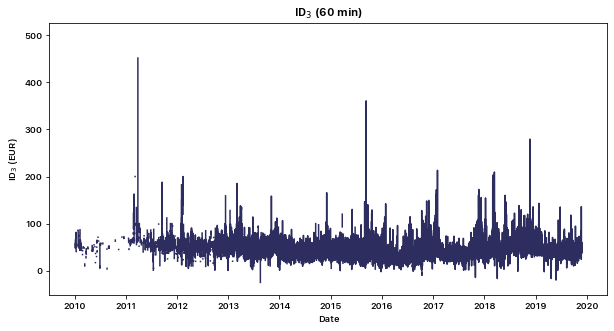

In [9]:
ID3 = pd.read_pickle(f"./ID3.pkl")

fig, ax = plt.subplots(figsize=(10, 5))
x = ID3['Instrument']
y = ID3['ID3']
# ax.bar(x, y)
ax.plot(x, y)
ax.set_xlim(x.min() - 0.05 * (x.max() - x.min()), x.max() + 0.05 * (x.max() - x.min()))
ax.set_ylim(y.min() - 0.05 * (y.max() - y.min()), y.max() + 0.05 * (y.max() - y.min()))
ax.set_title(r'ID$_3$ (60 min)')
ax.set_xlabel(r'Date')
ax.set_ylabel(r'ID$_3$ (EUR)');

# Plot monthly volume (ID, sum) and daily price (ID, mean) for years in given period


...

Year: 2010

...



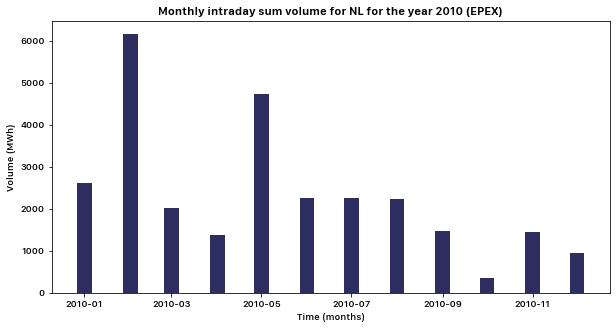

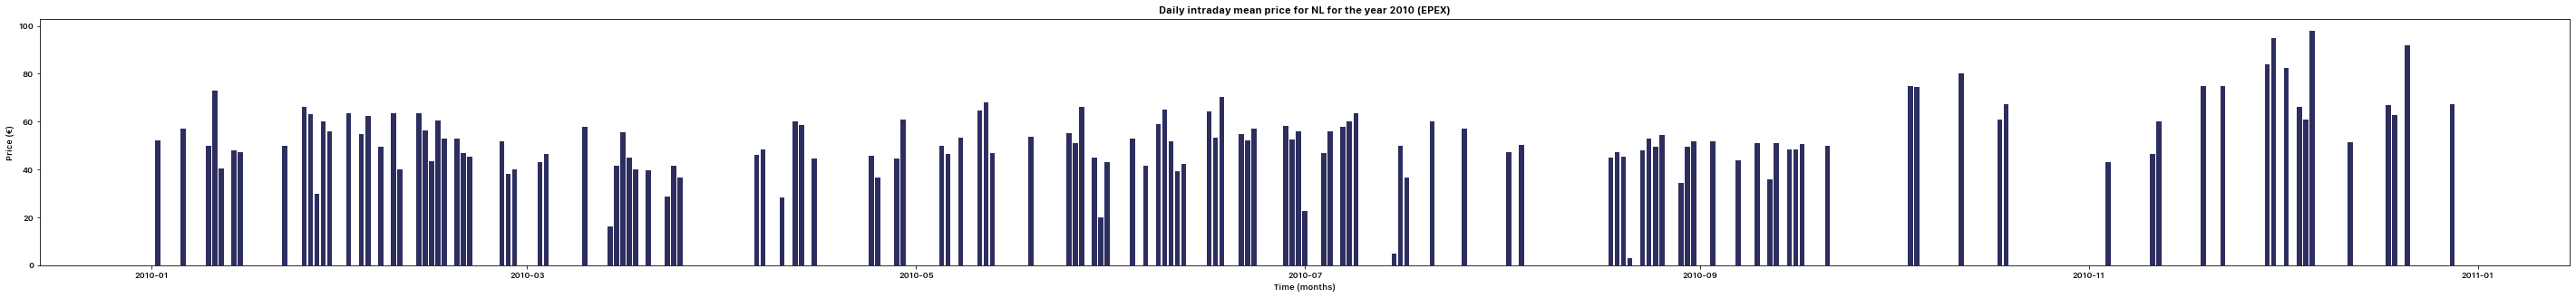


...

Year: 2011

...



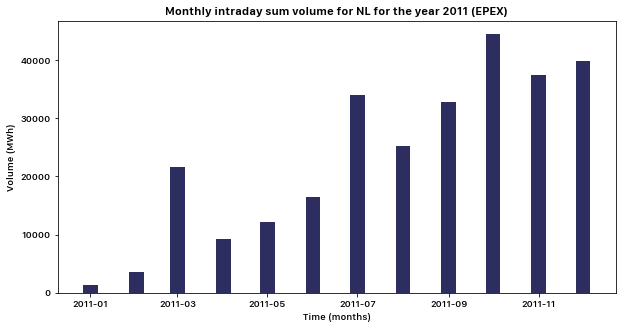

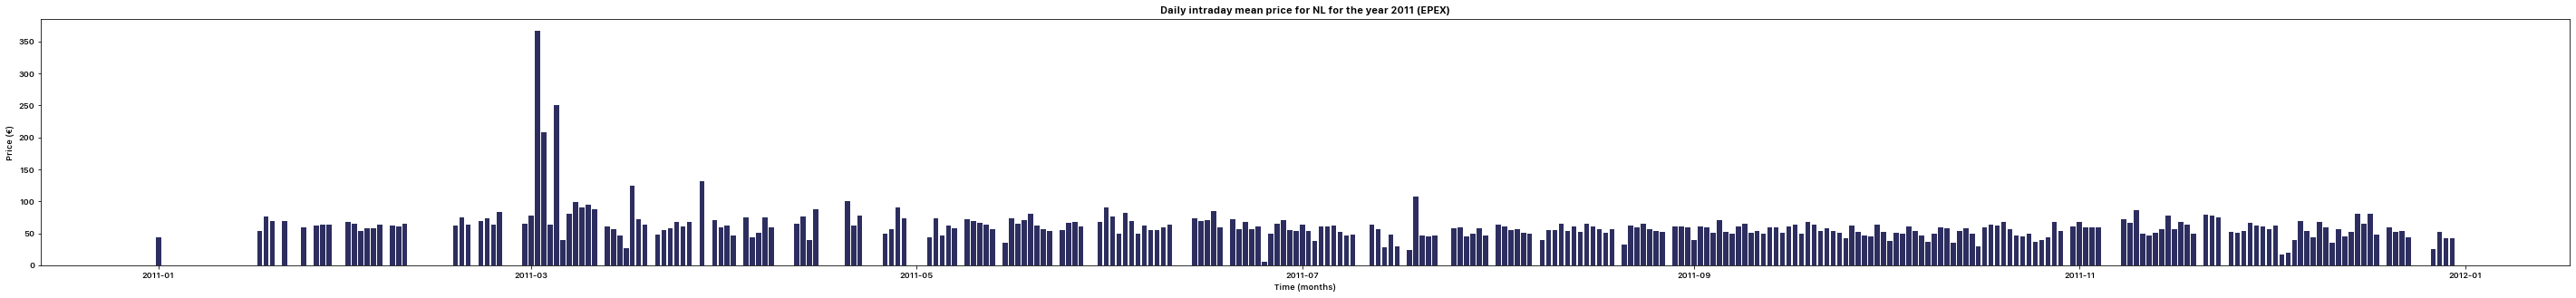


...

Year: 2012

...



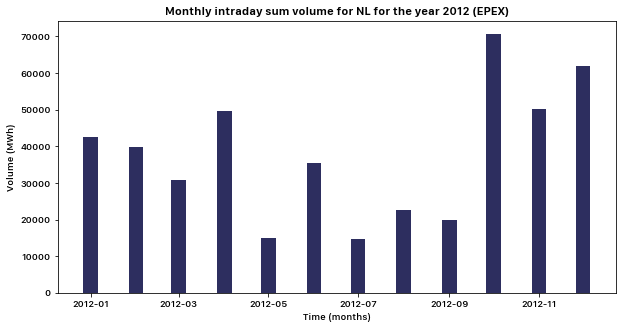

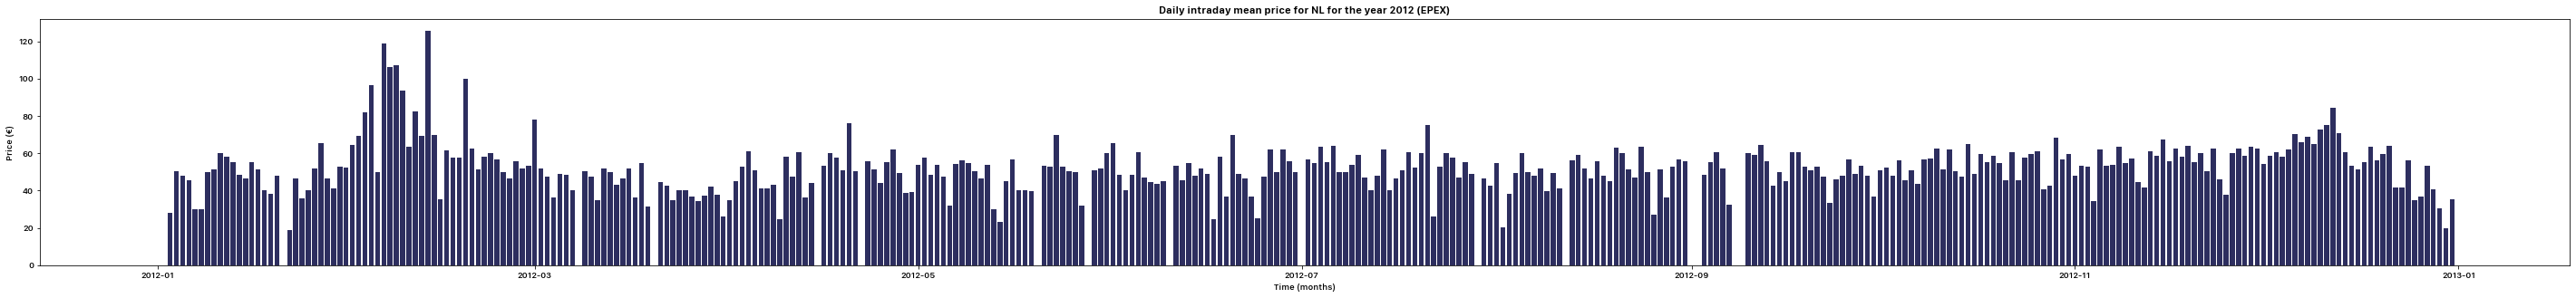


...

Year: 2013

...



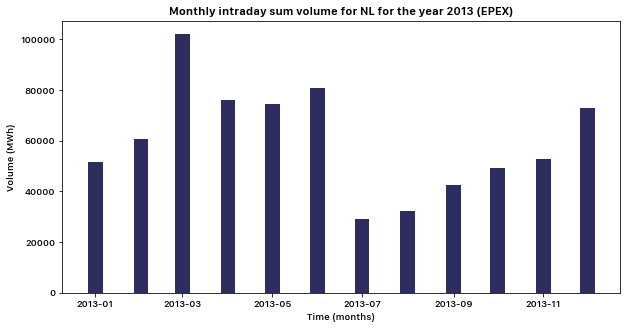

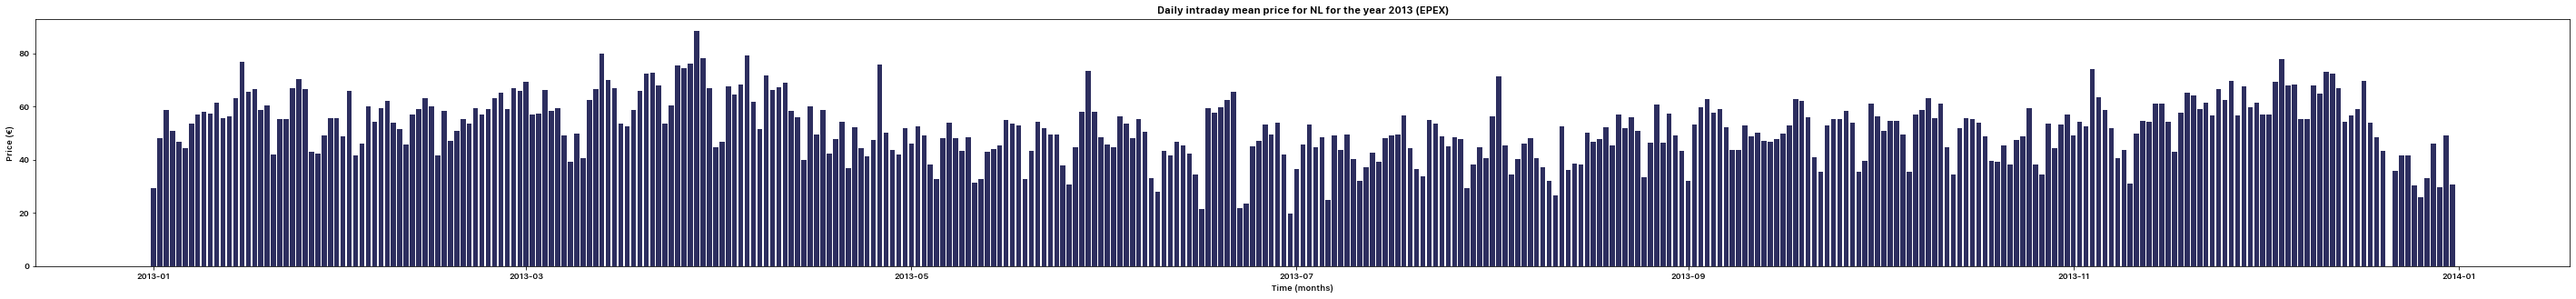


...

Year: 2014

...



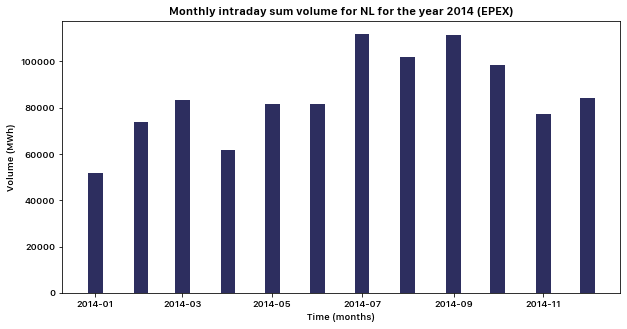

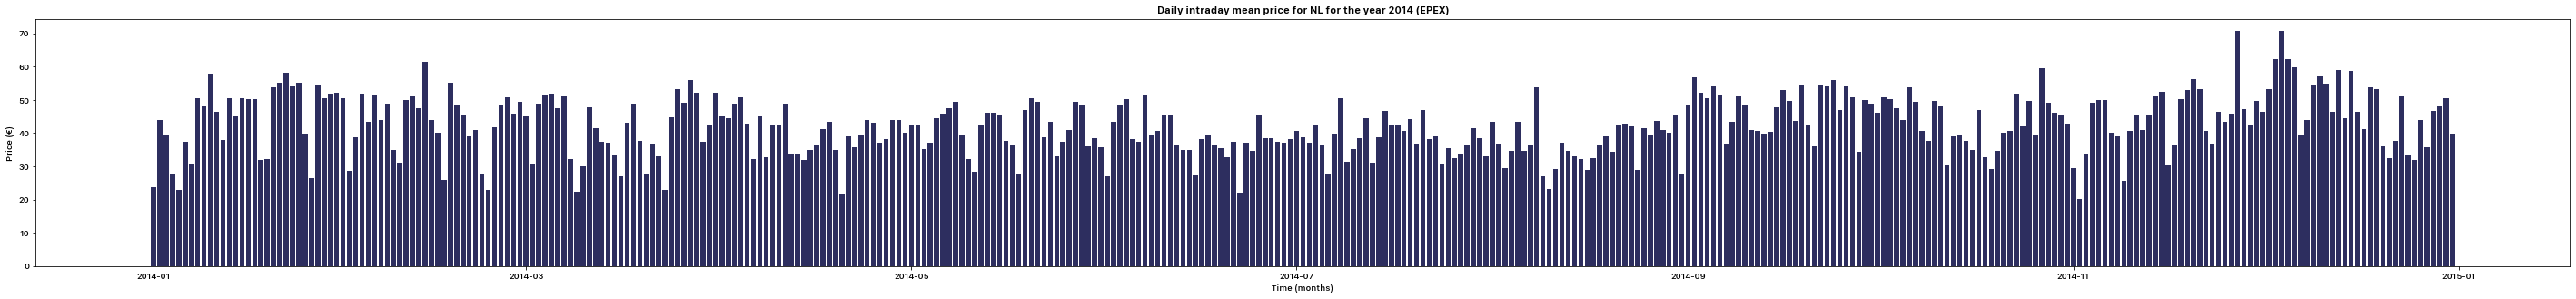


...

Year: 2015

...



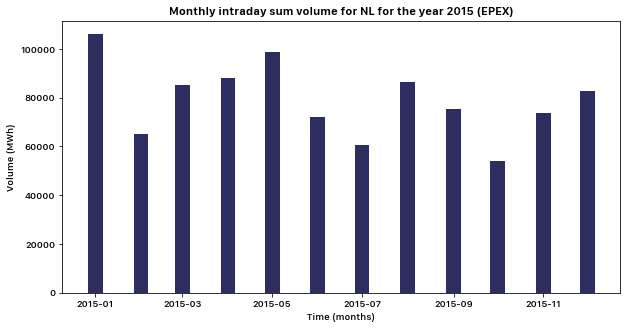

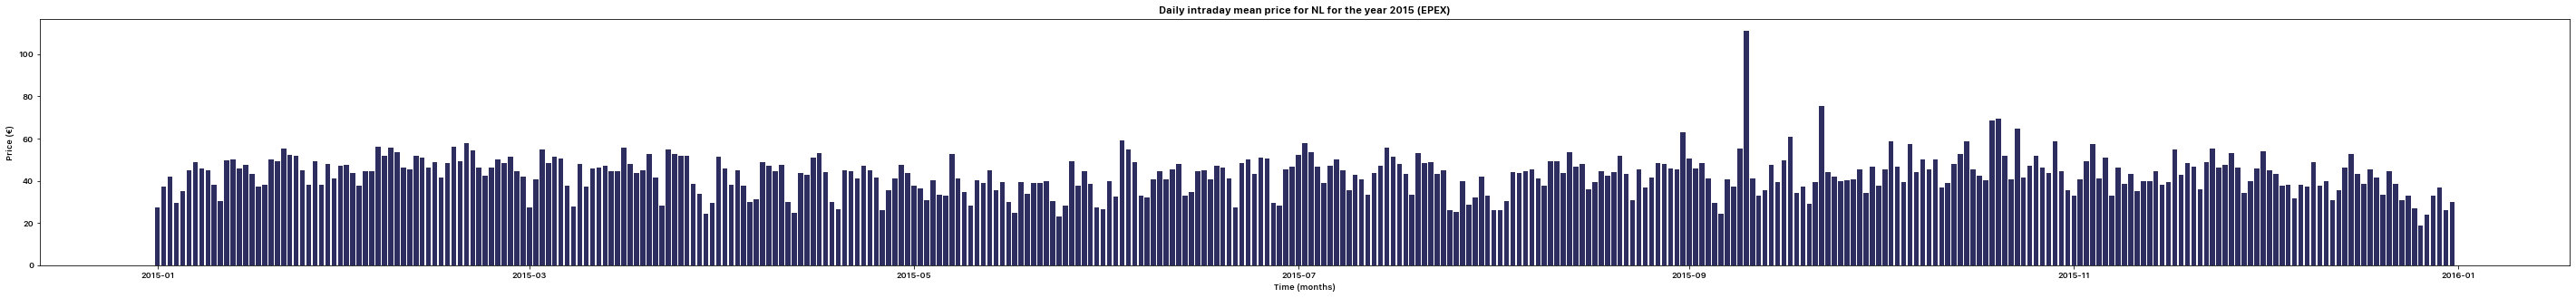


...

Year: 2016

...



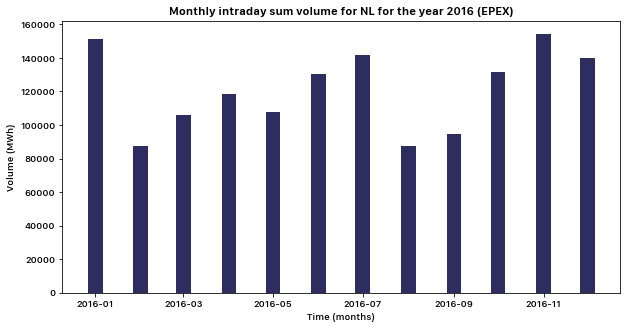

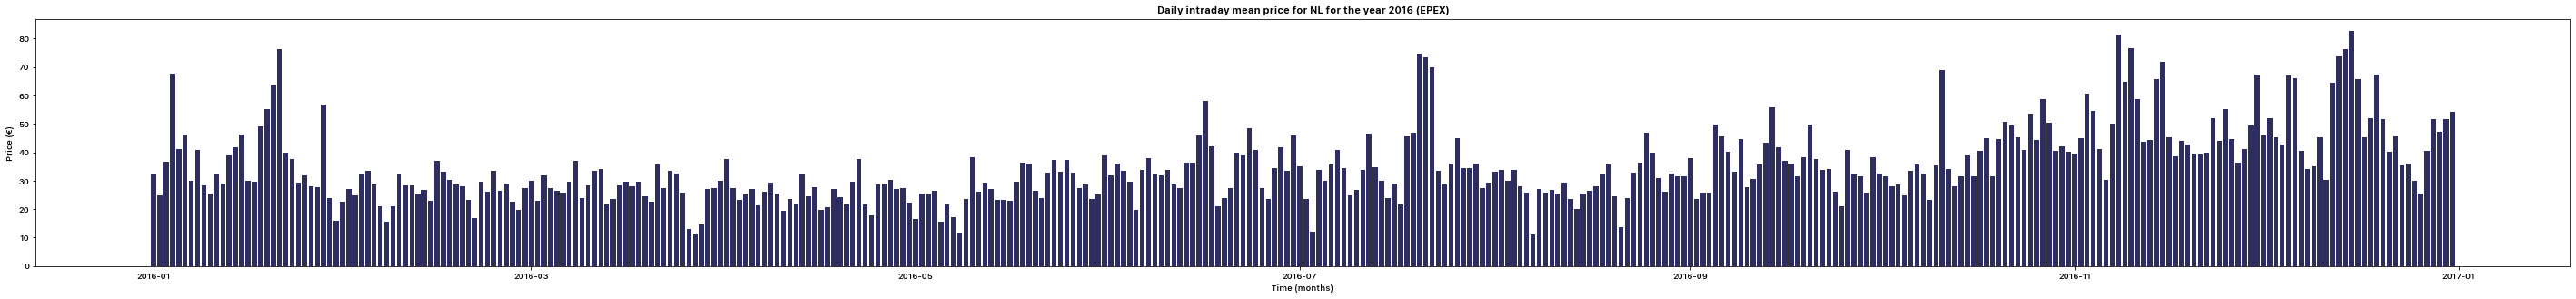


...

Year: 2017

...



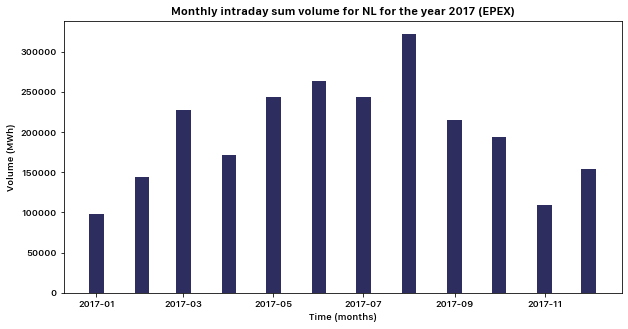

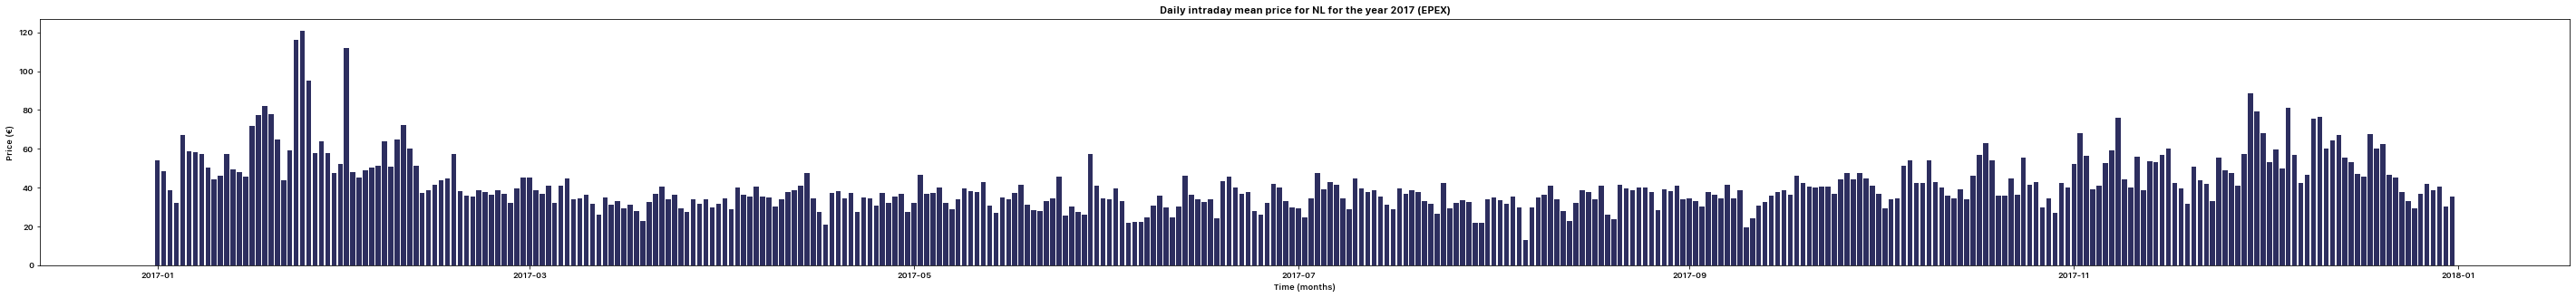


...

Year: 2018

...



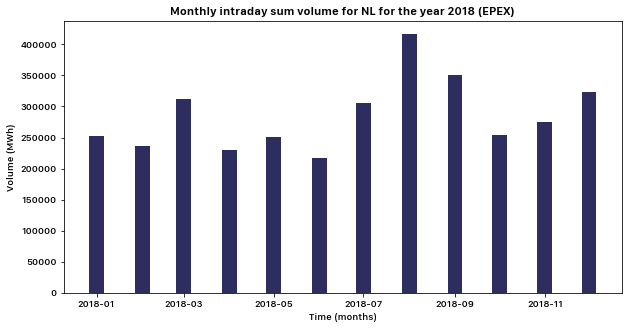

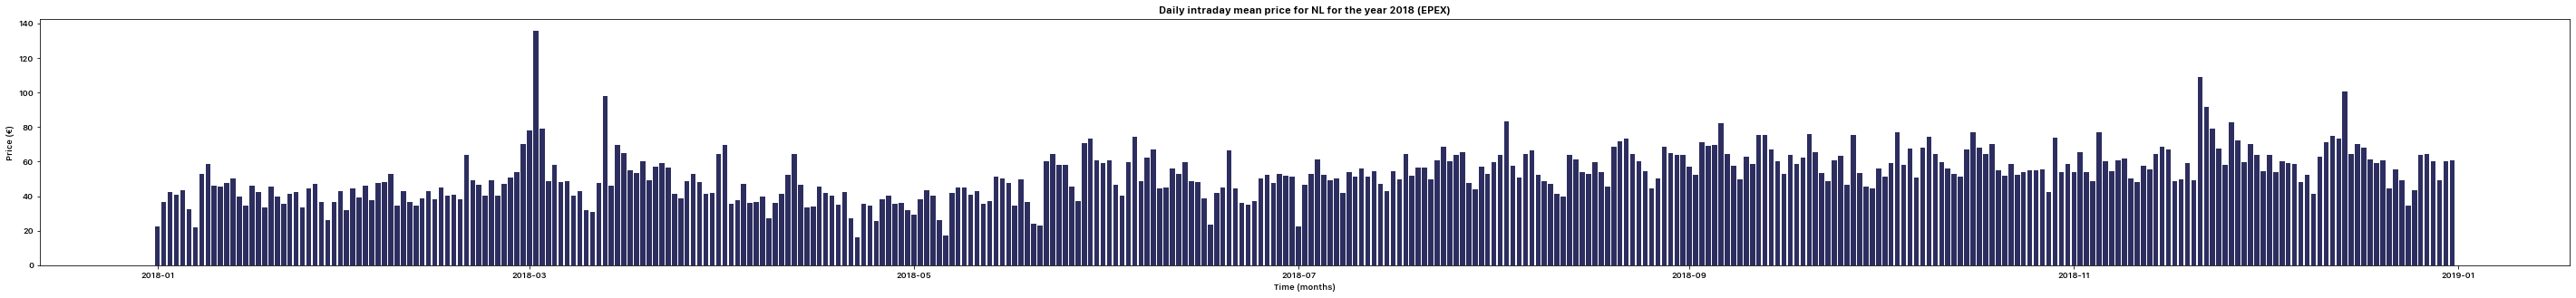


...

Year: 2019

...



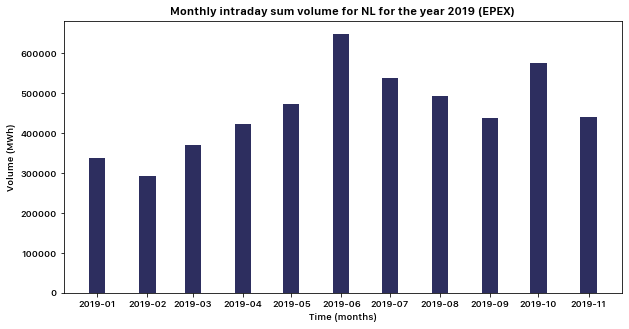

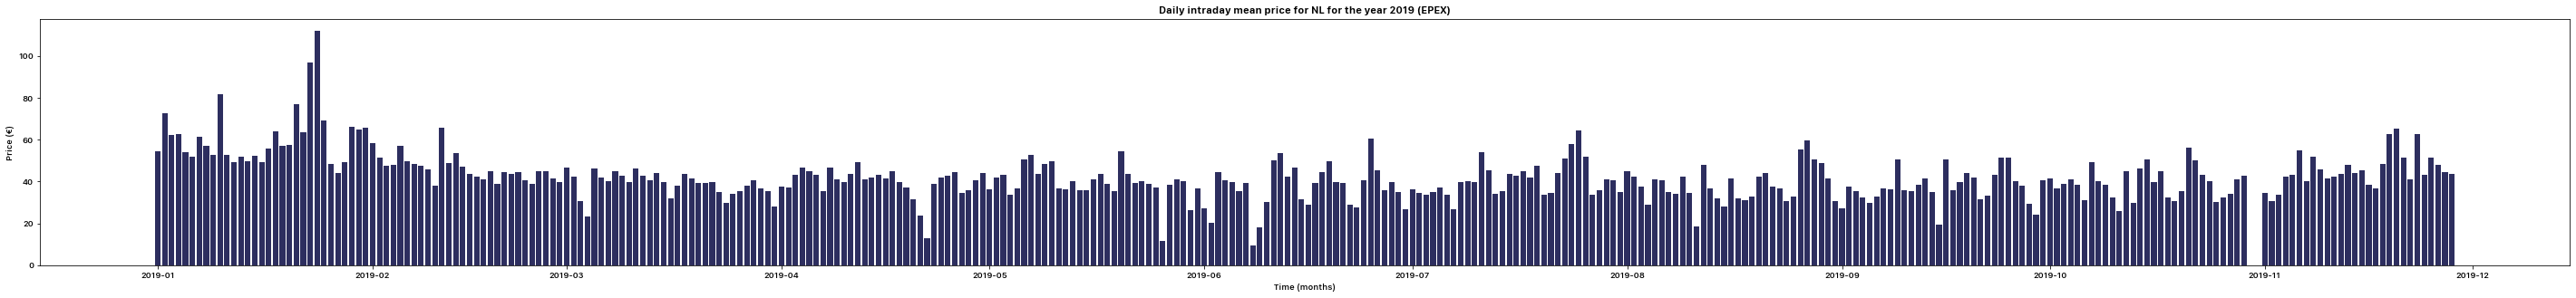

In [10]:
for y in years:

    y = int(y)

    print('')
    print(colored('...','white'))
    print('')
    print(colored(f'Year: {y}', 'blue'))
    print('')
    print(colored('...','white'))
    print('')

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(dfo_group[dfo_group.index.year == y].index, dfo_group[dfo_group.index.year == y]['Volume'], width=10)
    ax.set_title(f'Monthly intraday sum volume for {country} for the year {y} (EPEX)')
    ax.set_xlabel(r'Time (months)')
    ax.set_ylabel(r'Volume (MWh)')
    plt.show()

    fig, ax = plt.subplots(figsize=(50, 5))
    ax.bar(dfo_group2[dfo_group2.index.year == y].index, dfo_group2[dfo_group2.index.year == y]['Price'])
    # ax.bar(df_group[df_group.index.year == 2019].index, df_group[df_group.index.year == 2019]['Volume'], width=10)
    # ax.bar(df_group2['Date'], df_group2['Price'])
    ax.set_title(f'Daily intraday mean price for {country} for the year {y} (EPEX)')
    ax.set_xlabel(r'Time (months)')
    ax.set_ylabel(r'Price (€)')
    plt.show()

# Plot monthly volume (ID, sum) for the whole period

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(dfo_group['Date'], dfo_group['Volume'], width=20)
ax.set_title(f'Monthly intraday volume for {country} for the period {years[0]}–{years[-1]} (EPEX)')
ax.set_xlabel(r'Time (months)')
ax.set_ylabel(r'Volume (MWh)');

# Show intraday (df) grouped on differerent timescales (month, day, hour)

In [ ]:
print('')
print(colored('...','white'))
print('')
print(colored(f'(ID) Grouped by month', 'blue'))
print('')
print(colored('...','white'))
print('')

print(dfo_group)

print('')
print(colored('...','white'))
print('')
print(colored(f'(ID) Grouped by day', 'blue'))
print('')
print(colored('...','white'))
print('')

print(dfo_group2)

print('')
print(colored('...','white'))
print('')
print(colored(f'(ID) Grouped by hour', 'blue'))
print('')
print(colored('...','white'))
print('')

print(dfo_group3)

# Merge intraday (df) and day-ahead (df)

In [ ]:
# OG = pd.merge(dfo_group3, df_da2, how='outer', left_index=True, right_index=True)

# OG['Absolute'] = np.subtract(OG['Price'], OG['MCP'])
# OG['Percentual'] = 100 * np.divide(np.subtract(OG['Price'], OG['MCP']), OG['MCP'])

# print('')
# print(colored('...','white'))
# print('')
# print(colored(f'(DA & ID) Grouped by hour', 'blue'))
# print('')
# print(colored('...','white'))
# print('')

# print(OG)

# Plot absolute and percentual difference between day-ahead price (MCP) and intraday price (mean) for given period

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(OG.index, OG.Absolute)
# ax.set_title(f'Absolute difference between average EPEX (ID) and EPEX (DA) MCP for {country} for the period {years[0]}–{years[-1]}')
# ax.set_xlabel(r'Time (months)')
# ax.set_ylabel(r'Absolute difference (€)');

# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(OG.index, OG.Percentual)
# ax.set_title(f'Percentual difference between average EPEX (ID) and EPEX (DA) MCP for {country} for the period {years[0]}–{years[-1]}')
# ax.set_xlabel(r'Time (months)')
# ax.set_ylabel(r'Percentual difference (%)');

# Specify day

In [ ]:
datetime_of_interest = '2019-12-03 15:00:00'

# Calculate intraday price distribution and intraday cumulative volume for given day

In [ ]:
filtered_dates = pd.DataFrame()
filtered_dates = dfo.loc[dfo["Date"] == datetime_of_interest]

filtered_dates['Volume_weighted'] = filtered_dates['Price'] * filtered_dates['Volume']
filtered_dates['Cumulative volume'] = ''
filtered_dates['Relative volume'] = ''

volume_tot = filtered_dates['Volume'].sum()

df = filtered_dates
for idx, row in df.iterrows():
    df['Cumulative volume'][idx] = df.loc[df['Price'] <= df['Price'][idx]]['Volume'].sum()
    df['Relative volume'][idx] = df['Cumulative volume'][idx] / volume_tot

# quantiles = [0, 10, 25, 45, 55, 75, 90, 100]
# quantiles_val = list()
# quantiles_idx = list()
# for q in quantiles:
#     quantiles_val.append(filtered_dates['Price'].quantile(q/100))
#     quantiles_idx.append(f'Q{q}')

df = filtered_dates
quantiles = [0, 0.1, 0.25, 0.45, 0.55, 0.75, 0.9, 1.0]
quantiles_val = list()
quantiles_idx = list()

for q in quantiles:
    
    if q == 0:
        quantiles_val.append(df.sort_values('Relative volume', ascending=True).iloc[0]['Price'])
        continue

    if q == 1.0:
        quantiles_val.append(df.sort_values('Relative volume', ascending=False).iloc[0]['Price'])
        continue

    x1 = df.loc[df['Relative volume'] <= q].sort_values('Relative volume', ascending=False).iloc[0]['Relative volume']
    y1 = df.loc[df['Relative volume'] <= q].sort_values('Relative volume', ascending=False).iloc[0]['Price']
    x2 = df.loc[df['Relative volume'] >= q].sort_values('Relative volume', ascending=True).iloc[0]['Relative volume']
    y2 = df.loc[df['Relative volume'] >= q].sort_values('Relative volume', ascending=True).iloc[0]['Price']

    if y2 == y1:
        quantiles_val.append(y2)
    else:
        delta = (y2 - y1) / (x2 - x1)
        quantiles_val.append(y1 + (q - x1) * delta)

print('')
print(colored('...','white'))
print('')
print(colored(f'Finished successfully', 'green'))
print('')
print(colored('...','white'))
print('')

# Plot intraday price distribution and intraday cumulative volume for given day

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [3, 1]})
plt.suptitle(f'Product: {datetime_of_interest} (EPEX)')

x = filtered_dates['Time to delivery']
y = filtered_dates['Price']
ax1.scatter(x, y, s=filtered_dates['Volume'].apply(lambda x: x*5), alpha=0.5)
ax1.plot(x, y, linewidth=1, alpha=0.2)
ax1.set_xlim(x.min() - 0.05 * (x.max() - x.min()), x.max() + 0.05 * (x.max() - x.min()))
ax1.set_ylim(y.min() - 0.05 * (y.max() - y.min()), y.max() + 0.05 * (y.max() - y.min()))
ax1.set_title(f'Price distribution')
ax1.set_xlabel(r'Time to delivery (hours)')
ax1.set_ylabel(r'Price (EUR/MWh)')
ax1.invert_xaxis()

x = filtered_dates.sort_values('Price')['Relative volume']
y = filtered_dates.sort_values('Price')['Price']
[ax2.axhline(q, linewidth=1, alpha=0.2) for q in quantiles_val]
[ax2.axvline(q, linewidth=1, alpha=0.1) for q in quantiles]
ax2.plot(x, y, alpha=0.5)
ax2.set_xlim(x.min() - 0.05 * (x.max() - x.min()), x.max() + 0.05 * (x.max() - x.min()))
ax2.set_ylim(y.min() - 0.05 * (y.max() - y.min()), y.max() + 0.05 * (y.max() - y.min()))
ax2.set_title(f'Cumulative volume')
ax2.set_xlabel(r'Quantiles')
ax2.set_ylabel(r'Price (EUR/MWh)')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")